# Milestone 3: Text analysis
The hypothesis behind this model was that the textual information about movies would be predictive of the genres. In order to model this, we used a Dirichlet multinomial Bayesian model. 

In [1]:
%matplotlib inline

import os
import nltk
import random
import itertools
import numpy as np
import pandas as pd
from collections import Counter
from unidecode import unidecode
from nltk.corpus import stopwords
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
random.seed(42)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Grabbing the data
For now, we have a total sample of around 50,000 movies. For this model, however, we worked with a random sample of 5,000 films. We also only looked at the textual data (`overview` and `reviews`) and the list of genres (`genres`). 

In [2]:
raw = pd.read_json('../../data/themoviedb-sample-4-17-2017.json')
print(raw.shape)

# Keeping only genres, overviews, and reviews
raw = raw[['genres', 'reviews', 'overview']].copy()
print(raw.shape)
raw.head()

(9549, 32)
(9549, 3)


,genres,reviews,overview
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...
4,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...


## Determining $y$: Flattening `genres` into `genre`
TODO

In [3]:
raw['genres'].head()

0               [{u'name': u'Documentary', u'id': 99}]
1               [{u'id': 99, u'name': u'Documentary'}]
2                    [{u'id': 28, u'name': u'Action'}]
3    [{u'id': 28, u'name': u'Action'}, {u'id': 18, ...
4    [{u'id': 28, u'name': u'Action'}, {u'id': 18, ...
Name: genres, dtype: object

In [22]:
raw['genre_lists'] = raw.apply(lambda x: [y['name'] for y in x['genres']], axis = 1)
raw.head()

,genres,reviews,overview,genre_lists
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...,[Documentary]
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...,[Documentary]
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...,[Action]
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]"
4,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]"


In [162]:
df = raw.set_index(['overview']).apply(lambda x: pd.Series(x['genre_lists']), axis=1).stack().reset_index().drop_duplicates()[['overview',0]]
df.rename(columns = {0: 'genre'}, inplace = True)
print(df.shape)
df.head()

(9425, 2)


,overview,genre
0,Modern industrialization is no longer about st...,Documentary
1,The documentary is an analysis of the fascinat...,Documentary
2,A good-natured kung fu kid gets caught up in c...,Action
3,In Los Angeles a deadly plague called the 'Pan...,Action
4,In Los Angeles a deadly plague called the 'Pan...,Drama


In [163]:
df['genre'].value_counts()

Drama              1741
Comedy             1204
Documentary         907
Thriller            854
Action              675
Horror              640
Romance             518
Crime               375
Science Fiction     347
Family              341
Music               331
Adventure           313
Animation           268
Mystery             206
Fantasy             203
TV Movie            163
History             109
Foreign              99
War                  70
Western              61
Name: genre, dtype: int64

In [164]:
df.dropna(inplace = True)
print(df.shape)
df.head()

(9397, 2)


,overview,genre
0,Modern industrialization is no longer about st...,Documentary
1,The documentary is an analysis of the fascinat...,Documentary
2,A good-natured kung fu kid gets caught up in c...,Action
3,In Los Angeles a deadly plague called the 'Pan...,Action
4,In Los Angeles a deadly plague called the 'Pan...,Drama


In [165]:
# Number of unique movies
df['overview'].nunique()

4865

In [166]:
# Downsampling drama and comedy movies
index_to_drop = df[(df['genre'] == 'Drama') | (df['genre'] == 'Comedy')].sample(frac = 0.6)

df2 = df.drop(index_to_drop.index).copy()
print(df.shape, df2.shape)
df2['genre'].value_counts()

((9397, 2), (7632, 2))


Documentary        905
Thriller           851
Drama              696
Action             675
Horror             638
Romance            516
Comedy             480
Crime              373
Science Fiction    347
Family             340
Music              329
Adventure          312
Animation          266
Mystery            204
Fantasy            202
TV Movie           162
History            107
Foreign             99
War                 70
Western             60
Name: genre, dtype: int64

## Converting `overview` to word-frequency vectors
For movie overviews, we turned these into word-frequency vectors. 

In [167]:
# I realized that sometimes 'overview' was in my top words list; renaming it here 'protects' it
df2.rename(columns={'overview': 'movie_overview'}, inplace=True)

stops = set(nltk.corpus.stopwords.words('english'))
all_words_ever = []

def add_cols_for_all_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if len(word) > 2 and unidecode(word.lower()) not in stops]
        all_words_ever.extend(words)
    return row

def parse_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if word.lower() in top_words]
        for word in words:
            row[unidecode(word)] += 1        
    return row

In [168]:
df2 = df2.apply(lambda x: add_cols_for_all_words(x), axis = 1)
len(all_words_ever), len(set(all_words_ever))

(239464, 24427)

## Fitting the model
We have identified 25,820 unique words that appear, globally, across all the movie summaries. We cannot use all 25,820 word vectors, as we would then have the "curse of dimensionality" - an incredibly sparse matrix. Instead, following the Dirichlet homework, we only selected the most frequently occurring words as columns. Since this was akin to a tuning parameter, we cross-validated to find the optimal number of word vectors to include.

In [169]:
priors = df2['genre'].value_counts() / len(df2['genre'])
priors.values

array([ 0.11857966,  0.11150419,  0.09119497,  0.0884434 ,  0.08359539,
        0.06761006,  0.06289308,  0.04887317,  0.04546646,  0.04454927,
        0.04310797,  0.0408805 ,  0.03485325,  0.02672956,  0.02646751,
        0.02122642,  0.01401992,  0.0129717 ,  0.00917191,  0.00786164])

In [170]:
# Initialize model object
clf = MultinomialNB()

In [172]:
word_scores = []

for top_word_count in range(100, 500, 100):
    top_words = [word[0] for word in Counter(all_words_ever).most_common(top_word_count)]
    for word in top_words:
        df2[unidecode(word)] = 0

    this_df = pd.DataFrame()
    this_df = df2.apply(lambda x: parse_words(x), axis = 1)

    X = this_df[this_df.columns[-top_word_count:]]
    y = this_df['genre']
    y = y.apply(lambda x: str(x))
    print(X.shape, y.shape)

    scores = cross_val_score(clf, X, y, cv=5)
    word_scores.append({'top_word_count': top_word_count, 'average_score': scores.mean()})

word_scores = pd.DataFrame(word_scores)
word_scores.head()

((7632, 100), (7632,))
((7632, 200), (7632,))
((7632, 300), (7632,))
((7632, 400), (7632,))


,average_score,top_word_count
0,0.218962,100
1,0.231280,200
2,0.246862,300
3,0.249744,400


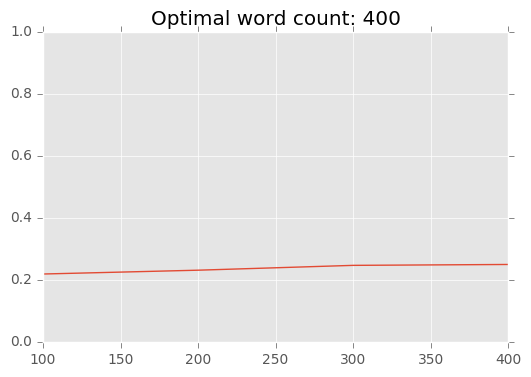

In [180]:
best_word_count = word_scores[word_scores['average_score'] == word_scores['average_score'].max()]['top_word_count'].item()

plt.plot(word_scores['top_word_count'], word_scores['average_score'])
plt.title('Optimal word count: {}'.format(best_word_count))
plt.ylim([0,1])
plt.show()

# TODO
1. random model as baseline
2. tune any other hyperparams?
3. add any other non-word vector features?
4. finish writing it up?

We have 16 unique genres which we are predicting. A random classifier would thus predict around 6% correctly. At present, we're able to predict with around 39% accuracy, using the top 500 words (by frequency) in film summary overviews.

### Confusion matrix

In [181]:
train = df2.sample(frac = 0.8)
test = df2.drop(train.index)
train.shape, test.shape

((6106, 402), (1526, 402))

In [182]:
X_train = train[train.columns[-best_word_count:]]
X_test = test[test.columns[-best_word_count:]]
y_train = train['genre']
y_test = test['genre']
X_train.shape, X_test.shape

((6106, 400), (1526, 400))

In [183]:
fitted = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = fitted.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

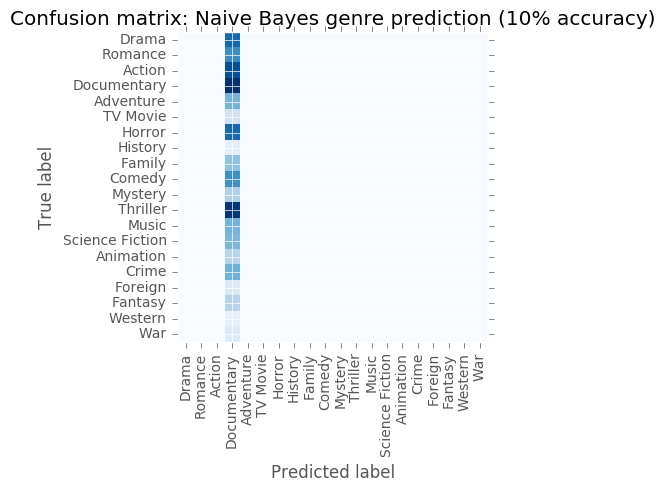

In [184]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=90)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Naive Bayes genre prediction ({:.0f}% accuracy)'.format(score*100))
plt.show()